In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../src'))
import SortedNoDupeBedOverlap as bdO
import io_utils
import stats_utils

### please download data from GEOXXXX (in process)

In [2]:
 mat, id2bc, id2peak = io_utils.read_atac_count_10x('./filtered_peak_bc_matrix')

In [3]:
## check number of cells and peaks
print('number of peaks: %d' % len(id2peak))
print('number of cells: %d' % len(id2bc))

number of peaks: 74633
number of cells: 36286


In [4]:
## read cell type specific peaks downloaded from GSE97887
ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../OCR_DB/GSE97887/', verbose = False)

In [5]:
intersect = set(bdO.BedOverlap(id2peak, sorted(ref_bk_peak), .5))

ref_subtype_peaks = []
for c, peaks in ref_subtype_peaks0:
    ref_subtype_peaks.append( (c, set(bdO.BedOverlap(id2peak, sorted(peaks), .5))) )

In [6]:
## number of cell type specific peaks 
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Ast 1757
End 429
Ex 5465
In 1721
Mic 1316
Oli 3530
Opc 1726


In [7]:
## calculate enrichment scores for every cell
scores = stats_utils.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 10)

In [8]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = id2bc
                       )

In [9]:
## to see a few columns of cell type scores
score_df.head()

,Ast,End,Ex,In,Mic,Oli,Opc
AAACGAAAGAATACTG-4,0.523347,0.876935,1.781270,1.112335,0.806753,0.357164,0.439892
AAACGAAAGACTAATG-4,2.085255,1.977696,0.367389,0.000000,5.425544,0.532315,2.462701
AAACGAAAGAGAGTAG-1,1.066832,4.800271,0.264368,0.109576,4.604105,0.785652,1.088151
AAACGAAAGAGCTGTG-3,3.886186,0.272715,0.350836,0.672615,1.305205,1.341117,2.575207
AAACGAAAGAGGAATG-5,0.600671,0.947015,1.479763,1.170600,0.921714,0.604637,0.682776


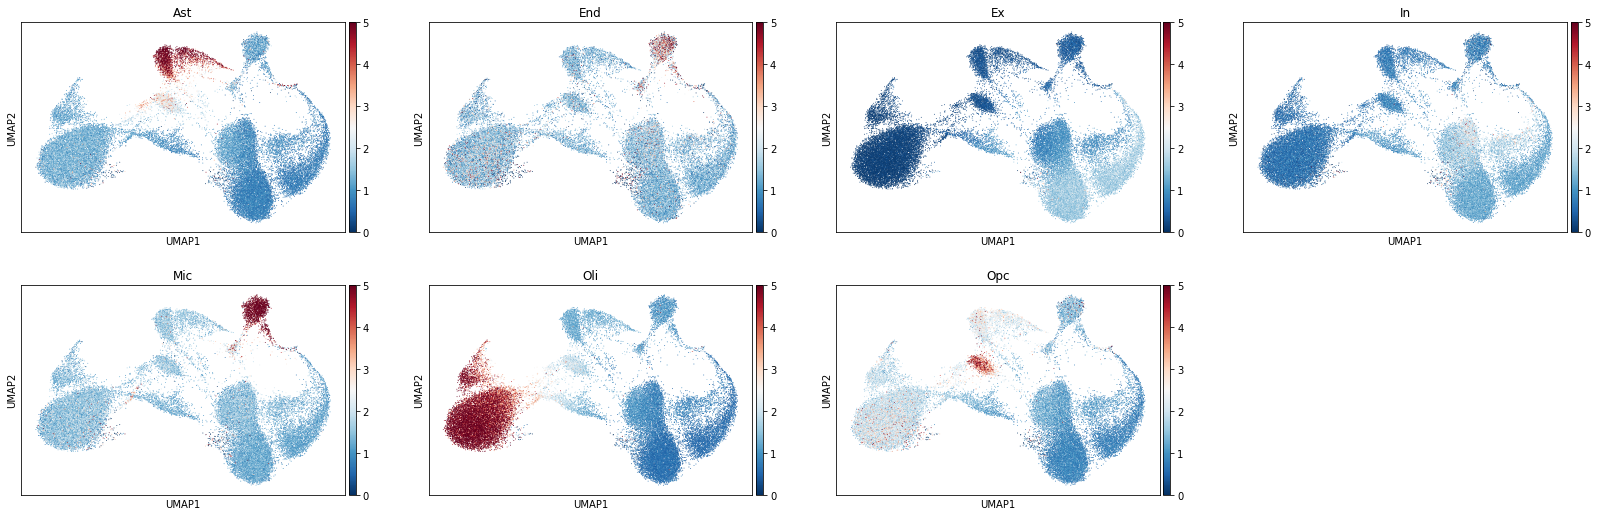

In [10]:
## visualization using scanpy
pcas = stats_utils.normalized_pca_from_sparse_mat(mat, n_pc = 20) 
            
data_obj = sc.AnnData(pcas, 
      obs = pd.DataFrame([], index = id2bc),
      )        

sc.pp.neighbors(data_obj, use_rep='X')
sc.tl.umap(data_obj) 

data_obj.obs = score_df

sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 5)